In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise_distances_argmin_min

In [2]:
FOLDER_PATH = "D:\\Google Drive\\Catherning Folder\\THU\\Thesis\\Recipe datasets\\scirep-cuisines-detail"
FILES = ["allr_recipes.txt","epic_recipes.txt","menu_recipes.txt"]

In [3]:
recipes = []
for file in FILES:
    with open(os.path.join(FOLDER_PATH,file)) as f:
        for i,recipe in enumerate(f):
            data = recipe.strip('\n').split('\t')
            recipes.append({"cuisine":data[0],"id":i,"ingredients":data[1:]})
        
df_train = pd.DataFrame(recipes)
df_train['all_ingredients'] = df_train['ingredients'].map(";".join)

### Data cleaning

In [4]:
# Fusion of the same cuisines
df_train=df_train.replace({"Mexico":"Mexican",
                           "mexico":"Mexican",
                           "chinese":"Chinese",
                           "China":"Chinese",
                           "France":"French",
                           "japanese":"Japanese",
                           "Japan":"Japanese",
                           "Thailand":"Thai",
                           "German":"Germany",
                           "India":"Indian",
                           "Israel":"Jewish",
                           "italian":"Italian",
                           "Italy":"Italian",
                           "Scandinavia":"Scandinavian",
                           "Vietnam":"Vietnamese",
                           "Korea":"Korean",
                           "korean":"Korean",
                           "EasternEuropean_Russian":"Eastern-Europe",
                           'Spain':'Spanish_Portuguese'})
df_train

,cuisine,id,ingredients,all_ingredients
0,Canada,0,"[egg, yeast, wheat, milk, lard]",egg;yeast;wheat;milk;lard
1,Canada,1,"[pork, carrot, pea, onion, potato]",pork;carrot;pea;onion;potato
2,Canada,2,[maple_syrup],maple_syrup
3,Canada,3,"[wheat, yeast, almond, honey, oat, date, veget...",wheat;yeast;almond;honey;oat;date;vegetable_oi...
4,Canada,4,"[butter, lovage, clam, wheat, onion, thyme, po...",butter;lovage;clam;wheat;onion;thyme;potato;ye...
...,...,...,...,...
57686,Italian,2453,"[kiwi, olive_oil, clam, white_wine, orange, sa...",kiwi;olive_oil;clam;white_wine;orange;salmon;f...
57687,Italian,2454,"[tomato, butter, beef, onion, red_wine, black_...",tomato;butter;beef;onion;red_wine;black_pepper...
57688,Italian,2455,"[vegetable, wheat, egg, cheese, olive_oil]",vegetable;wheat;egg;cheese;olive_oil
57689,Italian,2456,"[tomato, clam, black_pepper, parsley, celery, ...",tomato;clam;black_pepper;parsley;celery;macaroni


## Removing cuisines with not enough recipes

In [5]:
RECIPE_THRESHOLD=10
cuisine_count= df_train['cuisine'].value_counts()
to_drop = [cuisine_count[cuisine_count == el].index[0] for el in cuisine_count if el<RECIPE_THRESHOLD]
df_train = df_train[~df_train["cuisine"].isin(to_drop)]

In [6]:
# Saving the cleaned data
df_train.to_pickle(os.path.join(FOLDER_PATH,"full_data.pkl"))

### Removing part of the american recipes

#### Random sampling

In [7]:
# american_df = df_train[df_train["cuisine"]=="American"].sample(frac=0.9)
# df_train=df_train[~df_train.isin(american_df).all(1)]

# df_train = df_train[(df_train["cuisine"]!="American")]

#### PCA

In [8]:
cv = CountVectorizer()

x_american=cv.fit_transform(df_train[df_train["cuisine"]=="American"]['all_ingredients'].values)
df_train.loc[df_train["cuisine"]=="American","american_id"]=[i for i in range(x_american.shape[0])]
df_train[df_train["cuisine"]=="American"]

D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,cuisine,id,ingredients,all_ingredients,american_id
4437,American,4437,"[tomato, honey, chicken, mustard, onion]",tomato;honey;chicken;mustard;onion,0.0
4438,American,4438,"[feta_cheese, black_pepper, ginger, pecan, chi...",feta_cheese;black_pepper;ginger;pecan;chicken;...,1.0
4439,American,4439,"[cocoa, milk]",cocoa;milk,2.0
4440,American,4440,"[tomato, olive_oil, parmesan_cheese, macaroni,...",tomato;olive_oil;parmesan_cheese;macaroni;basi...,3.0
4441,American,4441,"[olive_oil, pepper, onion, thyme, potato, whit...",olive_oil;pepper;onion;thyme;potato;white_wine...,4.0
...,...,...,...,...,...
49622,American,7797,"[tomato, vinegar, okra, onion, lima_bean, corn...",tomato;vinegar;okra;onion;lima_bean;corn;cayen...,40145.0
49623,American,7798,"[orange, olive_oil, pork, garlic, oregano]",orange;olive_oil;pork;garlic;oregano,40146.0
49624,American,7799,"[butter, cane_molasses, wheat, vanilla, walnut...",butter;cane_molasses;wheat;vanilla;walnut;coco...,40147.0
49625,American,7800,"[butter, cane_molasses, wheat, blueberry, milk...",butter;cane_molasses;wheat;blueberry;milk_fat;...,40148.0


In [9]:
K_clusters=200

reduced_data = TruncatedSVD(n_components=2).fit_transform(x_american)
kmeans = MiniBatchKMeans(n_clusters=K_clusters, n_init=10)
kmeans.fit(reduced_data)
kmeans.labels_

array([ 99,  20,  79, ...,  83, 106,  10])

In [10]:
closest,_ = pairwise_distances_argmin_min(kmeans.cluster_centers_, reduced_data)
if np.unique(closest).shape[0]!=K_clusters:
    print(np.unique(closest).shape)
    print("https://stackoverflow.com/questions/21660937/get-nearest-point-to-centroid-scikit-learn")

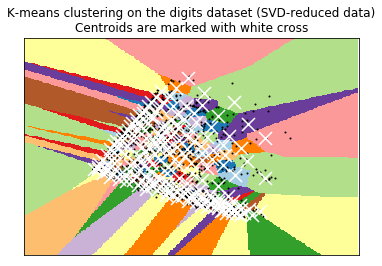

In [11]:
reduced_data = reduced_data[:2000]

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (SVD-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [12]:
# Saving the cleaned data
df_train.to_pickle(os.path.join(FOLDER_PATH,"cleaned_data.pkl"))